<h3><i><font color=#2471A3>Simple Battery Energy Arbitrage Optimization</font></i></h3>

24-h optimization of the Tesla Powerpack. Prices obtained from the EPEX-SPOT day-ahead market for DE/AT (Jan 24, 2018). Problem built with Gurobi 8.1.

In [1]:
import getpass
PathProj = "C://Users//{usr}//GoogleDrive//Projects//Battery Optimization".format(usr=getpass.getuser())
getpass.sys.path.append(PathProj)

# My modules
from batopt import *

BatteryDefns = pd.read_pickle("{}//Input//BatteryDefns.pkl".format(PathProj))
BatteryDefns

,Tesla Powerpack
Capacity [kWh],210.0
Power [kW],50.0
Energy-to-Power [h],4.2
DoD [%],100.0
Cycle Efficiency [%],89.0


<h4><i><font color=#BA4A00>1) Initialize Gurobi model and select battery</font></i></h4>

In [2]:
Prob = Model("Bat Opt 1")
BatteryModel = 'Tesla Powerpack'

Academic license - for non-commercial use only


<h4><i><font color=#BA4A00>2) Initialize decision variables</font></i></h4>

In [3]:
# Define time vector (arbitrary date)
time_vec = pd.date_range(start='1/01/2019 00:00', end='1/01/2019 23:45', freq='H')

# DV vector table
dv_vecs = pd.DataFrame(index=time_vec, columns=['E', 'Pch', 'Pdis', 'b'])

for dv_type in dv_vecs.columns:
    dv_vecs[dv_type] = create_DVs(Prob, dv_type, time_vec, BatteryModel, BatteryDefns)

# Final energy
dv_Efin = Prob.addVar(name="Efin", vtype=GRB.CONTINUOUS, lb=0, ub=BatteryDefns.at['Capacity [kWh]', BatteryModel])

<h4><i><font color=gray>Inspect dvs</font></i></h4>

In [4]:
Prob.update()
dv_vecs.head()

,E,Pch,Pdis,b
2019-01-01 00:00:00,"<gurobi.Var (E, 00:00)>","<gurobi.Var (Pch, 00:00)>","<gurobi.Var (Pdis, 00:00)>","<gurobi.Var (b, 00:00)>"
2019-01-01 01:00:00,"<gurobi.Var (E, 01:00)>","<gurobi.Var (Pch, 01:00)>","<gurobi.Var (Pdis, 01:00)>","<gurobi.Var (b, 01:00)>"
2019-01-01 02:00:00,"<gurobi.Var (E, 02:00)>","<gurobi.Var (Pch, 02:00)>","<gurobi.Var (Pdis, 02:00)>","<gurobi.Var (b, 02:00)>"
2019-01-01 03:00:00,"<gurobi.Var (E, 03:00)>","<gurobi.Var (Pch, 03:00)>","<gurobi.Var (Pdis, 03:00)>","<gurobi.Var (b, 03:00)>"
2019-01-01 04:00:00,"<gurobi.Var (E, 04:00)>","<gurobi.Var (Pch, 04:00)>","<gurobi.Var (Pdis, 04:00)>","<gurobi.Var (b, 04:00)>"


<h4><i><font color=#BA4A00>3) Formulate constraints</font></i></h4>
- Battery charge balance <br>
- Charge XOR discharge <br>
- Restore to initial charge

In [5]:
all_constrs(Prob, dv_vecs, dv_Efin, BatteryModel, BatteryDefns)

<h4><i><font color=#BA4A00>4) Define objective</font></i></h4>

In [6]:
# Read price, and convert to per kWh
Prices = pd.read_pickle("{}//Input//DEAT_20180124.pkl".format(PathProj))/1000

setObj(Prob, dv_vecs, Prices)

<h4><i><font color=#BA4A00>5) Solve</font></i></h4>

In [7]:
dv_soln = solve(Prob, dv_vecs, dv_Efin)
dv_soln.head()

Optimize a model with 73 rows, 97 columns and 194 nonzeros
Variable types: 73 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  Objective range  [9e-03, 4e-02]
  Bounds range     [1e+00, 2e+02]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 72 rows, 96 columns, 192 nonzeros
Variable types: 72 continuous, 24 integer (24 binary)

Root relaxation: objective 4.855720e+00, 17 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       4.8557198    4.85572  0.00%     -    0s

Explored 0 nodes (17 simplex iterations) in 0.04 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 4.85572 -0 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.855719827975e+00, best boun

,E,Pch,Pdis,b
2019-01-01 00:00:00,162.830094,50.0,0.0,1.0
2019-01-01 01:00:00,210.000000,0.0,0.0,0.0
2019-01-01 02:00:00,210.000000,0.0,0.0,-0.0
2019-01-01 03:00:00,210.000000,0.0,0.0,-0.0
2019-01-01 04:00:00,210.000000,0.0,0.0,-0.0


<h4><i><font color=#BA4A00>6) Visualize output</font></i></h4>

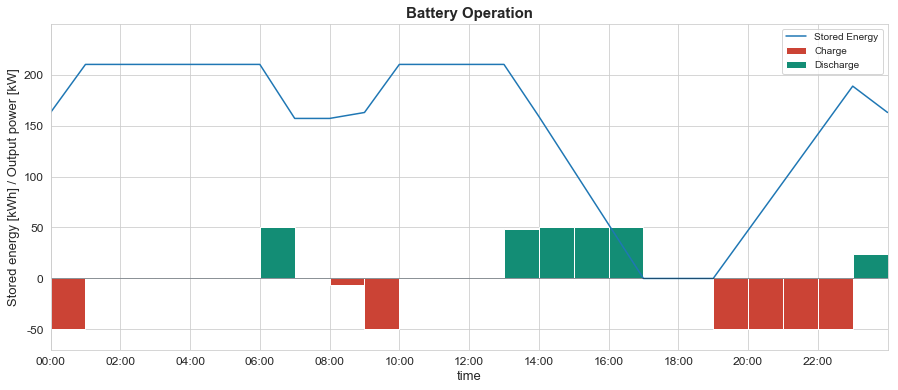

Generated revenue of 4.86 Euros 
from 2019-01-01 00:00:00 to 2019-01-02 00:00:00


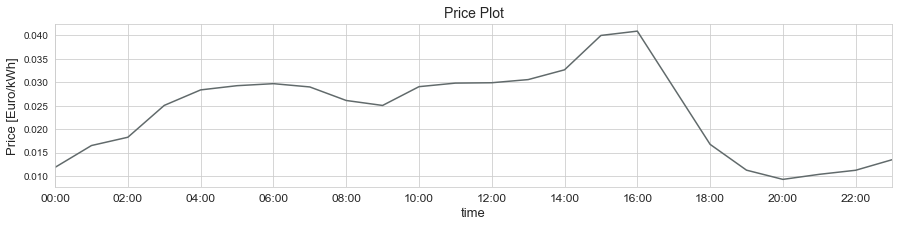

In [8]:
plot_batop(Prob, dv_soln)
plot_prices(Prices)

FINDINGS <br>
1) Model serves as the starting point to evaluate a battery's performance on a given market, and to assess the investment. <br>
2) Small gains from mere energy arbitrage strongly suggests the need for value-stacking (e.g. provide ancillary services to grid) <br>
3) Model assumes that the battery cannot affect the wholesale prices. When moving to battery fleet control, market dynamics must be included. <br>